# Oil Price Analysis

Import neccessary libraries and modules

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Configure logging
from logger import SetupLogger
# Assuming this class is defined in scripts/
from data_preprocessor import DataPreprocessor  

logger = SetupLogger(log_file='../logs/notebooks.log').get_logger()

# Set figure size
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

**Data Collection**

- Download the brent oil price data

In [2]:
# Set google drive url for loading the dataset
url = 'https://drive.google.com/file/d/1dJfhjX57bjvFnc1HHYVUhyW939QjIQE5/view?usp=drive_link'

# Setup the data preprocessor class
processor = DataPreprocessor(url, logger=logger)
# Load the data
price_data = processor.load_data()

Downloading...
From: https://drive.google.com/uc?export=download&id=1dJfhjX57bjvFnc1HHYVUhyW939QjIQE5
To: /home/noh/10Academy/oil-price-statistical-modeling/data/data.csv
100%|██████████| 156k/156k [00:00<00:00, 407kB/s]
/home/noh/10Academy/oil-price-statistical-modeling/scripts/data_preprocessor.py:51: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.data['Date'] = pd.to_datetime(self.data['Date'].str.strip(),  errors='coerce')


**Note**: always check `logs/notebooks.log` file for any log messages

In [3]:
# Explore the first 10 rows
price_data.head(10)

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
5,1987-05-27,18.60
6,1987-05-28,18.60
7,1987-05-29,18.58
8,1987-06-01,18.65
9,1987-06-02,18.68


In [4]:
# Explore the last 10 rows
price_data.tail(10)

,Date,Price
9001,2022-11-01,95.12
9002,2022-11-02,96.07
9003,2022-11-03,95.29
9004,2022-11-04,99.53
9005,2022-11-07,99.87
9006,2022-11-08,96.85
9007,2022-11-09,93.05
9008,2022-11-10,94.25
9009,2022-11-11,96.37
9010,2022-11-14,93.59


Create event dataset collected from various sources

In [5]:
# Define the events dictionary
events_dict = {
    "Gulf War (1990-1991)": {"start": "1990-08-02", "end": "1991-02-28"},
    "September 11 Attacks (2001)": {"start": "2001-09-11", "end": "2001-09-11"},
    "2003 Invasion of Iraq": {"start": "2003-03-20", "end": "2011-12-18"},
    "2008 Financial Crisis": {"start": "2008-09-15", "end": "2009-07-01"},
    "Arab Spring (2010-2012)": {"start": "2010-12-18", "end": "2012-12-18"},
    "Libyan Civil War (2011)": {"start": "2011-02-15", "end": "2011-10-23"},
    "U.S. Shale Oil Boom (2010s)": {"start": "2010-01-01", "end": "2019-12-31"},
    "OPEC Production Cuts (2016-2017)": {"start": "2016-11-30", "end": "2017-06-30"},
    "Iran Nuclear Deal and Sanctions (2015-2018)": {"start": "2015-07-14", "end": "2018-05-07"},
    "COVID-19 Pandemic (2020)": {"start": "2020-03-11", "end": "2022-09-30"},
    "OPEC+ Response to COVID-19 (2020)": {"start": "2020-04-09", "end": "2020-12-31"},
    "Russia-Ukraine Conflict (2022)": {"start": "2022-02-24", "end": "2022-09-30"},
    "Global Economic Recovery (2021-2022)": {"start": "2021-01-01", "end": "2022-09-30"}
}

# Convert the events dictionary to a DataFrame
events_data = pd.DataFrame.from_dict(events_dict, orient='index')
events_data.reset_index(inplace=True)
events_data.columns = ['Event', 'Start', 'End']

# Convert Start and End to datetime
events_data['Start'] = pd.to_datetime(events_data['Start'])
events_data['End'] = pd.to_datetime(events_data['End'])


In [6]:
events_data

,Event,Start,End
0,Gulf War (1990-1991),1990-08-02,1991-02-28
1,September 11 Attacks (2001),2001-09-11,2001-09-11
2,2003 Invasion of Iraq,2003-03-20,2011-12-18
3,2008 Financial Crisis,2008-09-15,2009-07-01
4,Arab Spring (2010-2012),2010-12-18,2012-12-18
5,Libyan Civil War (2011),2011-02-15,2011-10-23
6,U.S. Shale Oil Boom (2010s),2010-01-01,2019-12-31
7,OPEC Production Cuts (2016-2017),2016-11-30,2017-06-30
8,Iran Nuclear Deal and Sanctions (2015-2018),2015-07-14,2018-05-07
9,COVID-19 Pandemic (2020),2020-03-11,2022-09-30


Combine the price data with event data

In [7]:
def merge_event(events_data: pd.DataFrame, price_data: pd.DataFrame) -> pd.DataFrame:
    # Ensure Date, Start, and End columns are in datetime format
    price_data['Date'] = pd.to_datetime(price_data['Date'])
    events_data['Start'] = pd.to_datetime(events_data['Start'])
    events_data['End'] = pd.to_datetime(events_data['End'])

    # Create a DataFrame that contains each price date with corresponding events
    events_expanded = pd.DataFrame({
        'Date': pd.date_range(start=events_data['Start'].min(), end=events_data['End'].max(), freq='D')
    })

    # Merge the expanded events data with events_data to assign event names
    merged_data = pd.merge_asof(
        events_expanded.sort_values('Date'), 
        events_data.sort_values('Start'), 
        left_on='Date', 
        right_on='Start', 
        direction='backward'
    )

    # Merge the price data with the merged event data
    price_data = price_data.merge(merged_data[['Date', 'Event']], on='Date', how='left')

    # Fill the 'Event' column with 'No Event' where there is no match
    price_data['Event'].fillna('No Event', inplace=True)

    return price_data


# Apply the function to merge events to each price date
price_data = merge_event(events_data, price_data)



/tmp/ipykernel_230657/1645236865.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  price_data['Event'].fillna('No Event', inplace=True)


In [8]:

# Now price_data contains the original price data along with the corresponding events
price_data.head(10)  # View the combined data


,Date,Price,Event
0,1987-05-20,18.63,No Event
1,1987-05-21,18.45,No Event
2,1987-05-22,18.55,No Event
3,1987-05-25,18.60,No Event
4,1987-05-26,18.63,No Event
5,1987-05-27,18.60,No Event
6,1987-05-28,18.60,No Event
7,1987-05-29,18.58,No Event
8,1987-06-01,18.65,No Event
9,1987-06-02,18.68,No Event


In [9]:
price_data.iloc[8011:8021]

,Date,Price,Event
8011,2018-12-07,61.71,OPEC Production Cuts (2016-2017)
8012,2018-12-10,60.29,OPEC Production Cuts (2016-2017)
8013,2018-12-11,59.73,OPEC Production Cuts (2016-2017)
8014,2018-12-12,59.94,OPEC Production Cuts (2016-2017)
8015,2018-12-13,59.03,OPEC Production Cuts (2016-2017)
8016,2018-12-14,58.56,OPEC Production Cuts (2016-2017)
8017,2018-12-17,57.59,OPEC Production Cuts (2016-2017)
8018,2018-12-18,55.26,OPEC Production Cuts (2016-2017)
8019,2018-12-19,55.60,OPEC Production Cuts (2016-2017)
8020,2018-12-20,52.84,OPEC Production Cuts (2016-2017)


### Data Cleaning and Preprocessing

Inspect the dataset for completeness and structure

In [10]:
processor.inspect(price_data)

Dimensions (rows, columns): (9011, 3)

Data Types:
Date     datetime64[ns]
Price           float64
Event            object
dtype: object

No missing values found.

Unique Values in Each Column:
Date     9011
Price    5015
Event      14
dtype: int64
Number of duplicate rows: 0

Summary Statistics for Numeric Columns:


,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


**Detect Outliers**

- Box plot

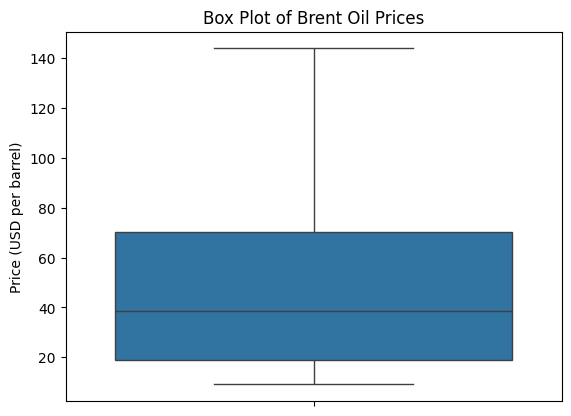

In [11]:
# Assuming 'price_data' is your DataFrame containing the 'Price' column
sns.boxplot(data=price_data, y='Price')
plt.title('Box Plot of Brent Oil Prices')
plt.ylabel('Price (USD per barrel)')
plt.show()

- No outliers detected in the price data

### Exploratory Data Analysis

- Descriptive Statistics

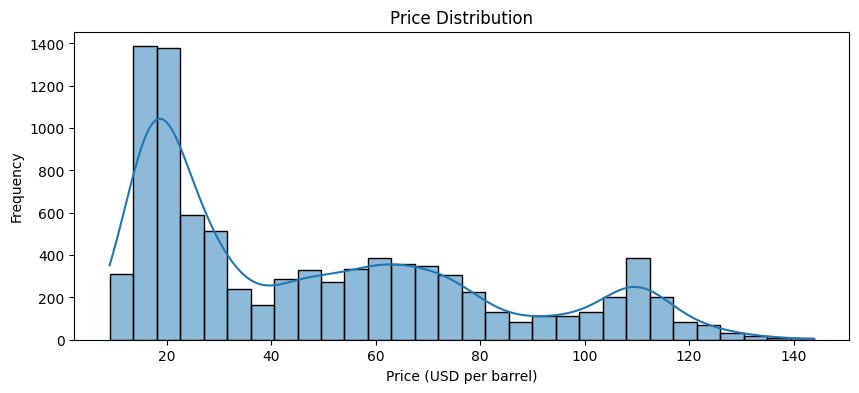

In [12]:
# Visualize the price distribution
plt.figure(figsize=(10, 4))
sns.histplot(price_data['Price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price (USD per barrel)')
plt.ylabel('Frequency')
plt.show()


- Event Distribution

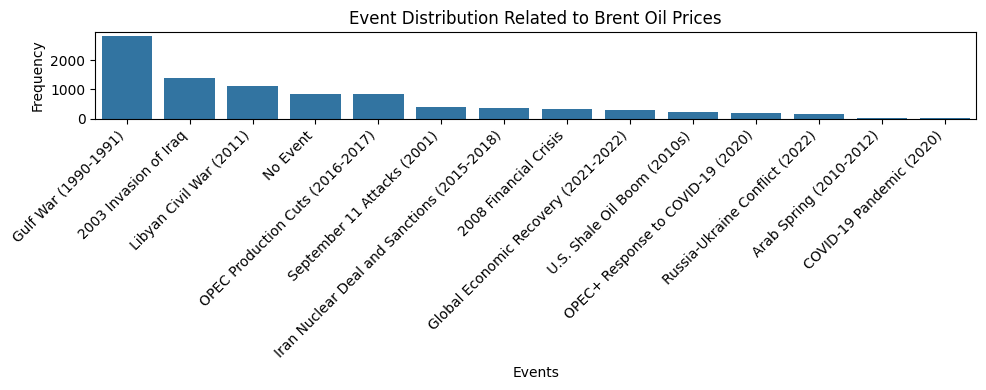

In [13]:
# Assuming 'Event' is the column containing the names of the events in price_data
event_counts = price_data['Event'].value_counts()

plt.figure(figsize=(10, 4))
sns.barplot(x=event_counts.index, y=event_counts.values)
plt.title('Event Distribution Related to Brent Oil Prices')
plt.xlabel('Events')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

Plot Time Series Data:

- Create a line graph to visualize price trends over time.

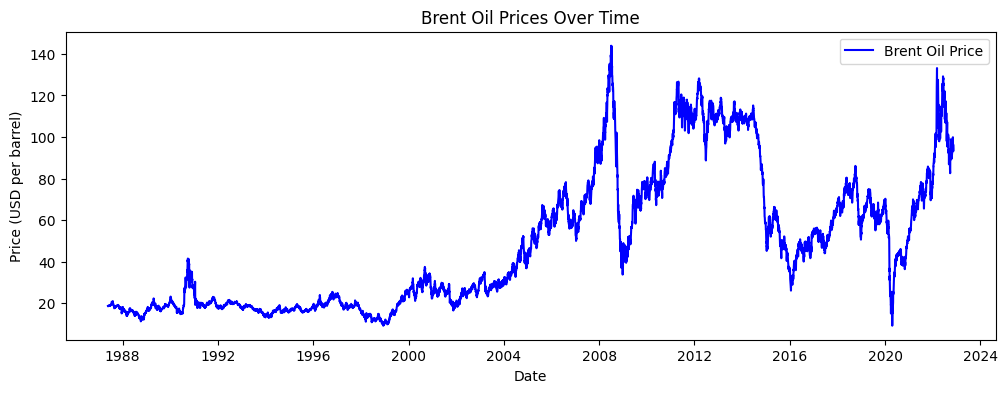

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(price_data['Date'], price_data['Price'], label='Brent Oil Price', color='blue')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
# plt.axvline(x='Date', color='red', linestyle='--', label='Event Marker')
plt.legend()
plt.show()


**Analysis Seasonality**
- Aggregate prices by year and visualize seasonal patterns.

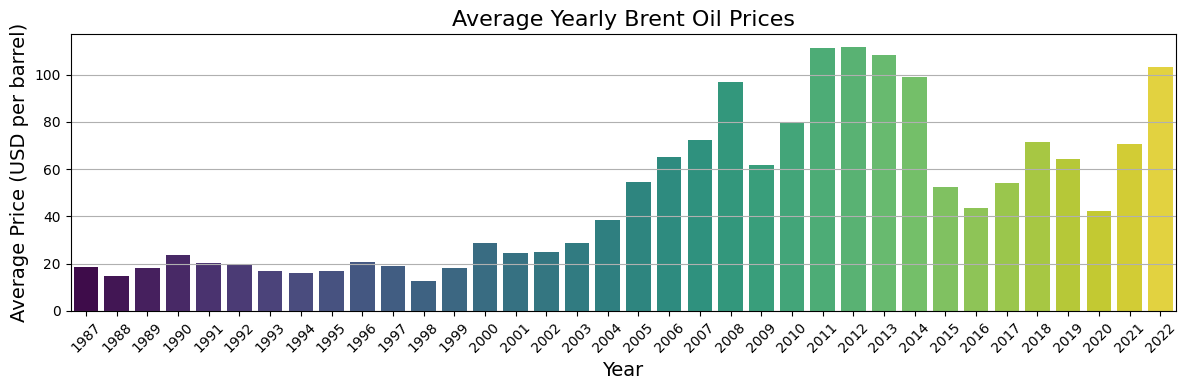

In [15]:
# Extract the year from the Date
price_data['Year'] = price_data['Date'].dt.year

# Calculate average price per year
yearly_avg = price_data.groupby('Year')['Price'].mean().reset_index()

# Plot yearly average prices
plt.figure(figsize=(12, 4))
sns.barplot(x='Year', y='Price', data=yearly_avg, hue='Year', legend=False, palette='viridis')
plt.title('Average Yearly Brent Oil Prices', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Price (USD per barrel)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**Scatter Plots for Price Fluctuations:**

- Generate scatter plots to observe price fluctuations associated with specific events.

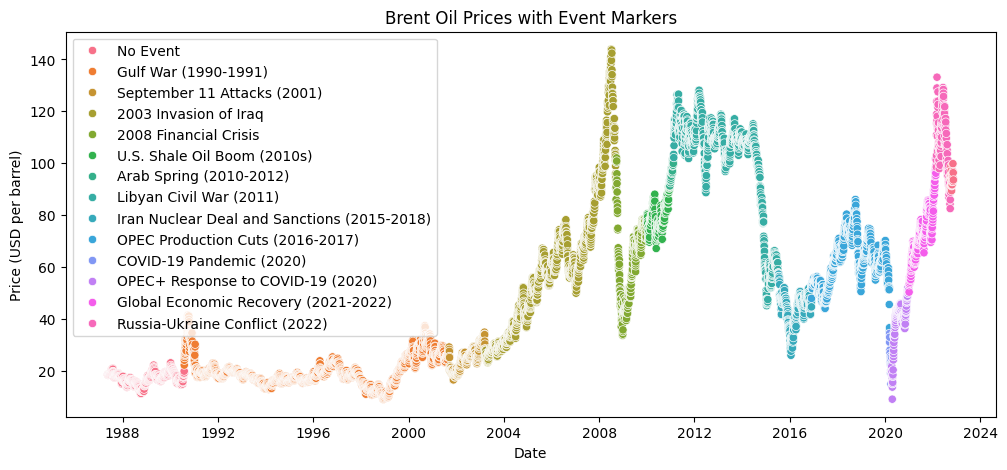

In [16]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x='Date', y='Price', hue='Event', data=price_data)
plt.title('Brent Oil Prices with Event Markers')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()
